---
title: "Return Period"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

## Bilbao, Spain

![](/archive/figures/bilbao-map.png)

## Today

![](640px-Guggenheim_museum_Bilbao_HDR-image.jpg)

## August 1983

![](/archive/figures/bilbao-flood-cars.jpg)

On Friday, August 26, 1983, Bilbao was celebrating its Aste Nagusia or Great Week, the main annual festivity in the city, when it and other municipalities of the Basque Country, Burgos, and Cantabria suffered devastating flooding due to heavy rains. In 24 hours, the volume of water registered 600 liters per square meter. Across all the affected areas, the weather service recorded 1.5 billion tons of water. In areas of Bilbao, the water reached a height of 5 meters (15 feet). Transportation, electricity and gas services, drinking water, food, telephone, and many other basic services were severely affected. 32 people died in Biscay, 4 people died in Cantabria, 2 people died in Alava, and 2 people died Burgos. 5 more people went missing.

## How often will such rainfall happen?

How often does it rain 50 mm in 1 day? What about 100 mm in 1 day? How big is a "once-in-a-century event"?

Let's examine Bilbao's daily rainfall (mm), between 1947 to 2021


In [1]:
#| code-summary: "import stuff"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
import urllib.request
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import altair as alt
alt.data_transformers.disable_max_rows()
from scipy.stats import genextreme

In [2]:
#| code-summary: "define function and download data"
def download_data(station_name, station_code):
    url_daily = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    url_monthly = 'https://www.ncei.noaa.gov/data/gsom/access/'
#     download daily data - uncomment to make this work
    urllib.request.urlretrieve(url_daily + station_code + '.csv',
                               station_name + '_daily.csv')
    # download monthly data
    urllib.request.urlretrieve(url_monthly + station_code + '.csv',
                               station_name + '_monthly.csv')
download_data('BILBAO', 'SPE00120611')

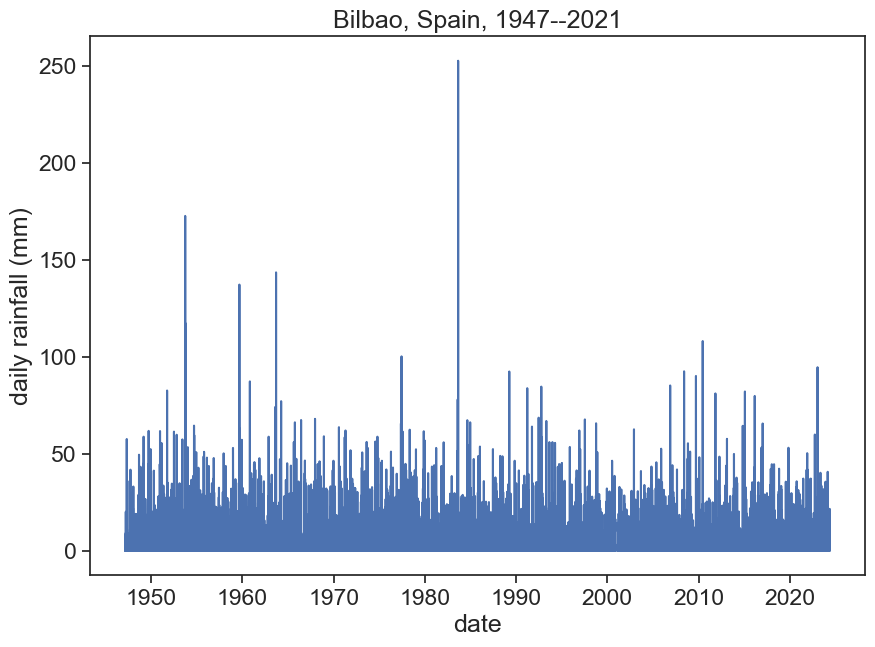

In [3]:
#| code-summary: "load data and plot precipitation"
df = pd.read_csv('BILBAO_daily.csv',
                 sep=",",
                 parse_dates=['DATE'],
                 index_col='DATE')
# IMPORTANT!! daily precipitation data is in tenths of mm, divide by 10 to get it in mm.
df['PRCP'] = df['PRCP'] / 10

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df['PRCP'])
ax.set(xlabel="date",
       ylabel="daily rainfall (mm)",
       title="Bilbao, Spain, 1947--2021"
      )
ax.annotate("26 August 1983",
             xy=(pd.to_datetime('1983-08-26'), 2500), xycoords='data',
             xytext=(0.7, 0.95), textcoords='axes fraction',
             fontsize=16, va="center",
             arrowprops=dict(facecolor='black', shrink=0.05));

On the week of 22-28 August 1983, Bilbao's weather station measured 45 cm of rainfall!

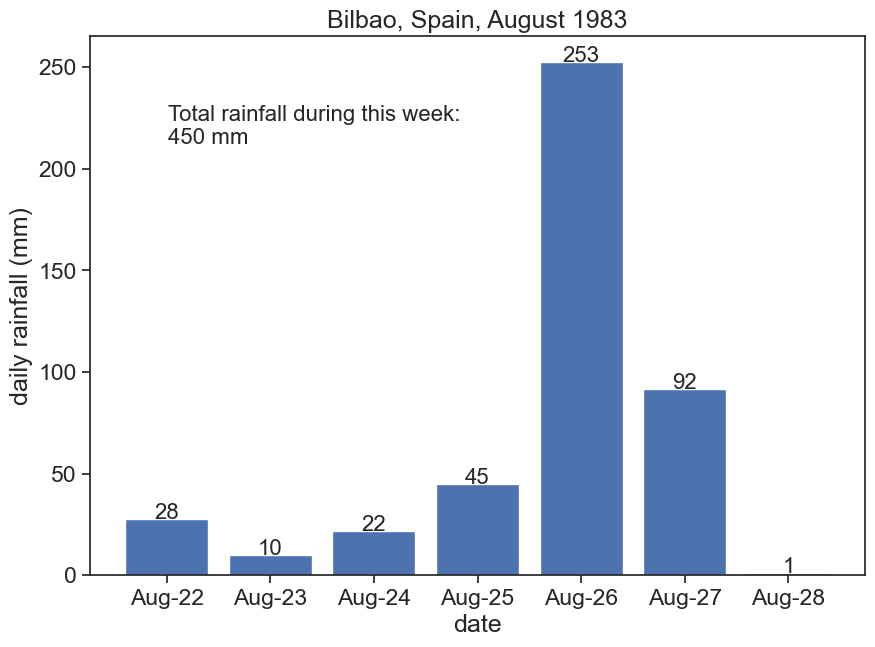

In [4]:

fig, ax = plt.subplots(figsize=(10,7))
one_week = df.loc['1983-08-22':'1983-08-28', 'PRCP']
bars = ax.bar(one_week.index, one_week)
ax.set_xlabel("date")
ax.set_ylabel("daily rainfall (mm)")
ax.set_title("Bilbao, Spain, August 1983")

# write daily rainfall
for i in range(len(one_week)):
    ax.text(one_week.index[i], one_week.iloc[i], f"{one_week.iloc[i]:.0f}", ha="center", fontsize=16)
    # ax.text(one_week.index[i], one_week[i], f"{one_week[i]:.0f}", ha="center", fontsize=16);

ax.text(0.1, 0.8, f"Total rainfall during this week:\n{one_week.sum():.0f} mm",
        transform=ax.transAxes, fontsize=16)
    
# Define the date format
# https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
date_form = DateFormatter("%b-%d")
ax.xaxis.set_major_formatter(date_form)
# Ensure a major tick for each day using (interval=1)
# https://matplotlib.org/stable/api/dates_api.html#date-tickers
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

Let's analyze this data and find out how rare such events are. First we need to find the annual maximum for each hydrological year. Do we see any seasonal patterns with our eyes? Play with the widget below.

In [5]:
#| code-summary: "widget"
# Altair only recognizes column data; it ignores index values.
# You can plot the index data by first resetting the index
# I know that I've just made 'DATE' the index, but I want to have this here nonetheless so I can refer to this in the future
df_new = df.reset_index()
source = df_new[['DATE', 'PRCP']]

brush = alt.selection_interval(encodings=['x'])

base = alt.Chart(source).mark_line().encode(
    x = 'DATE:T',
    y = 'PRCP:Q'
).properties(
    width=600,
    height=200
)

upper = base.encode(
    alt.X('DATE:T', scale=alt.Scale(domain=brush)),
    alt.Y('PRCP:Q', scale=alt.Scale(domain=(0,100)))
)

lower = base.properties(
    height=60
).add_params(brush)

alt.vconcat(upper, lower)

alt.VConcatChart(...)

Let's do what we learned already in the previous lectures, and plot monthly precipitation averages. For Bilbao, we will consider the hydrological year starting on 1 August.

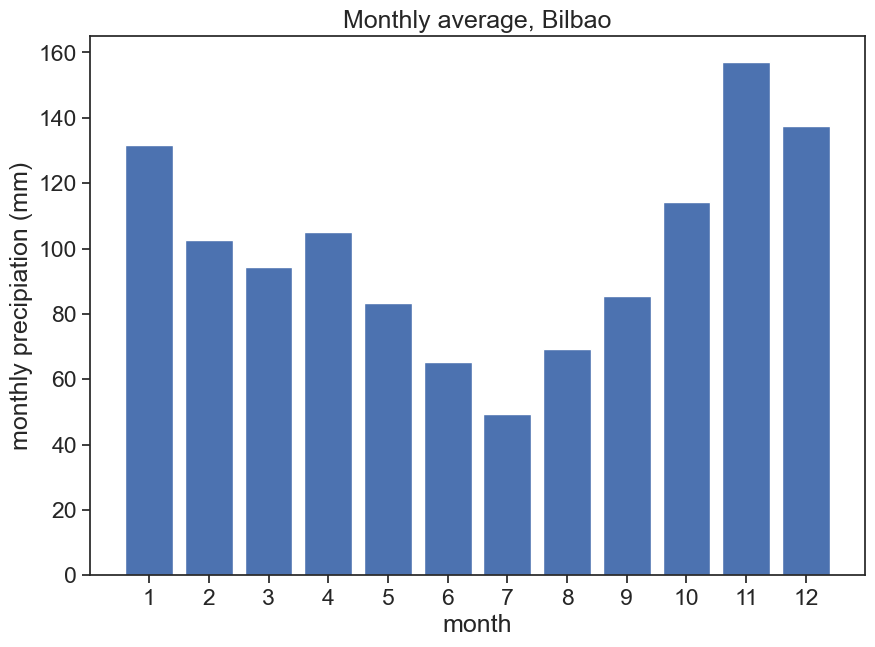

In [6]:
#| code-summary: "calculate and plot monthly precipitation averages"
df_month = df['PRCP'].resample('ME').sum().to_frame()
df_month_avg = (df_month['PRCP']
                  .groupby(df_month.index.month)
                  .mean()
                  .to_frame()
               )
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_month_avg.index, df_month_avg['PRCP'])
ax.set(xlabel="month",
       ylabel="monthly precipiation (mm)",
       title="Monthly average, Bilbao",
       xticks=np.arange(1,13));

* Top: Histogram of annual daily precipitation maximum events.  
* Bottom: The cumulative answers the question: "How many events can be found **below** a given threshold?"

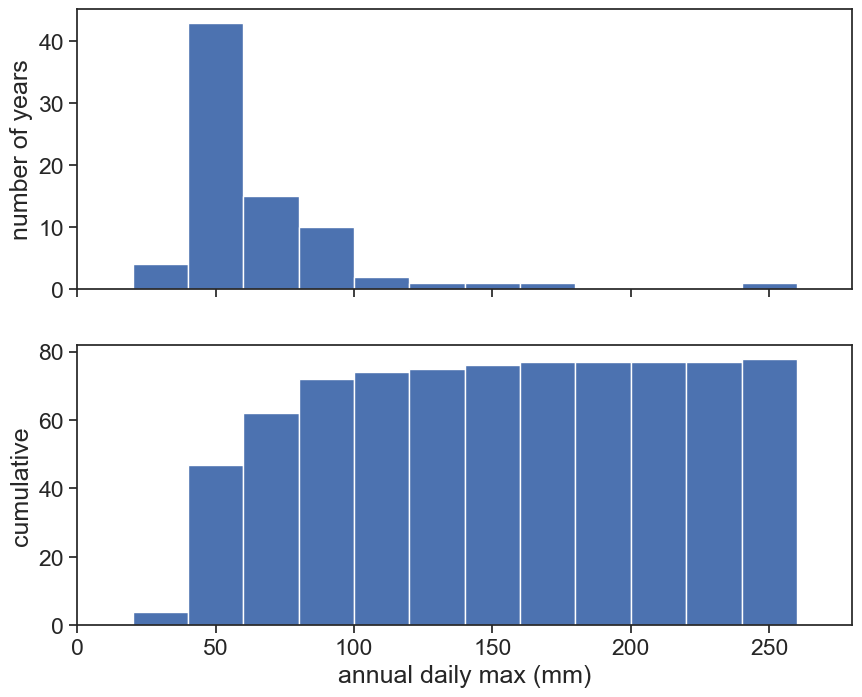

In [7]:
#| code-summary: "calculate max annual and plot histograms"
max_annual = (df['PRCP'].resample('YE-JUL')
                        .max()
                        .to_frame()
             )


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

h=max_annual['PRCP'].values

bins=np.arange(0,270,20)
ax1.hist(h, bins=bins)
ax2.hist(h, bins=bins, cumulative=1)

ax1.set(ylabel="number of years")
ax2.set(xlabel="annual daily max (mm)",
        ylabel="cumulative",
        xlim=[0,280]);

* Top: We can normalize the histogram such that the total area is 1. Now the histogram is called `probability density function (pdf)`. The probability is NOT the pdf, but the area between two thresholds.
* Bottom: The cumulative now becomes a probability between 0 and 1. It is now called `cumulative density function (cdf)`. The cdf answers the question: "What is the probability to choose an event **below** a given threshold?"

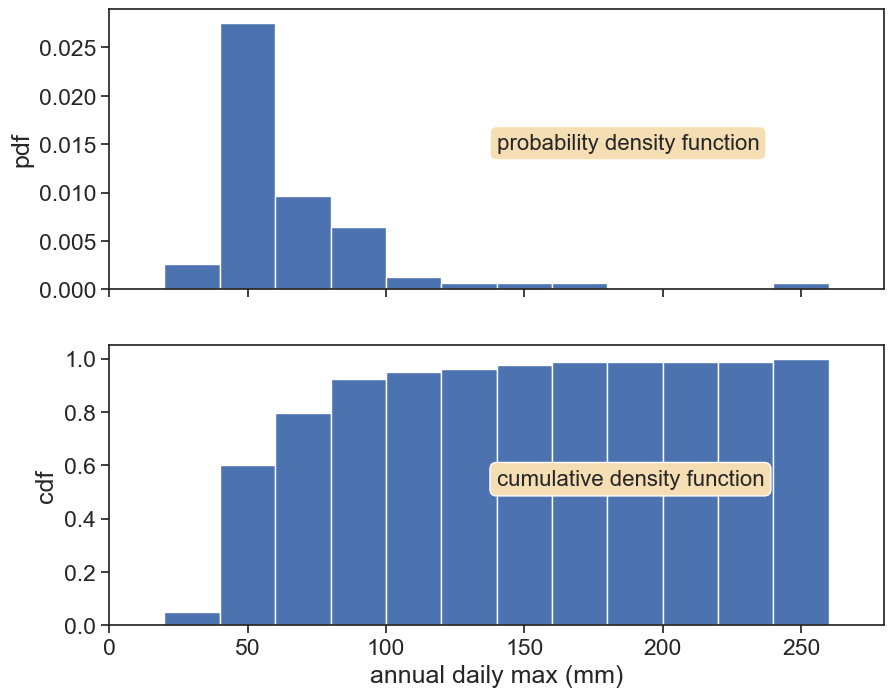

In [8]:
#| code-summary: "plot pdf and cdf"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax1.hist(h, bins=bins, density=True)
ax2.hist(h, bins=bins, cumulative=1, density=True)

ax1.set(ylabel="pdf")
ax2.set(xlabel="annual daily max (mm)",
        ylabel="cdf",
        xlim=[0,280]
        )
ax1.text(0.5, 0.5, "probability density function",
         transform=ax1.transAxes, fontsize=16,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=1))
ax2.text(0.5, 0.5, "cumulative density function",
         transform=ax2.transAxes, fontsize=16,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=1));

We are interested in extreme events, and we want to estimate how many years, **on average**, do we have to wait to get an annual maximum **above** a given threshold?

This question is very similar to what we asked regarding the cdf. 🤔  
We switched the word "below" for "above". The complementary of the cumulative is called the exceedance (or survival) probability:

$$
\text{exceedance, survival} = 1 - \text{cdf}
$$

In [9]:
#| code-summary: "define useful function to plot pdf and survival"
def plot_pdf_and_survival(survival):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)

    ax1.hist(h, bins=bins, density=True, histtype='stepfilled', alpha=0.2)
    ax2.hist(h, bins=bins, density=True, histtype='stepfilled', alpha=0.2, cumulative=-1)

    params = genextreme.fit(h)
    rain_max = 200.0
    rain = np.arange(0,rain_max)
    pdf = genextreme(c=params[0], loc=params[1], scale=params[2]).pdf
    cdf = genextreme(c=params[0], loc=params[1], scale=params[2]).cdf
    ax1.plot(rain, pdf(rain), 'r-', lw=5, alpha=0.6, clip_on=False)
    ax2.plot(rain, 1-cdf(rain), 'r-', lw=5, alpha=0.6, clip_on=False)
    ax1.set(ylabel="probability density")
    ax2.set(xlabel="annual daily max (mm)",
            ylabel="survival = 1-cdf",
            xlim=[0,200])

    # survival = 0.20
    threshold = genextreme(c=params[0], loc=params[1], scale=params[2]).ppf(1-survival)
    xfill = np.linspace(threshold, rain_max, 100)
    ax1.fill_between(xfill, pdf(xfill), color='None', hatch="//",edgecolor='k', label=f"{survival:.0%} of the area")
    ax2.plot([0, threshold, threshold], [survival, survival ,0], color="black", ls=":")
    ax2.text(20, survival, "{:.0f}%".format(100*survival), ha="left", va="bottom", fontsize=16)

    ax1.set(title=("we'll wait "+
                r"$\bf{" + "on\;average" + "}$ "+
                f"({survival:.0%})" +
                r"$^{-1}=$" +
                f"({survival:.2f})" +
                r"$^{-1}=$" +
                f" {1/survival:.0f} years\nfor a yearly maximum above {threshold:.0f} mm"
                )
        )
    ax1.legend(loc="upper right", frameon=False)
    ax2.text(100, 0.95, "the survival shows the probability\nthat next year's annual daily max\nis above a given threshold",
            va="top")

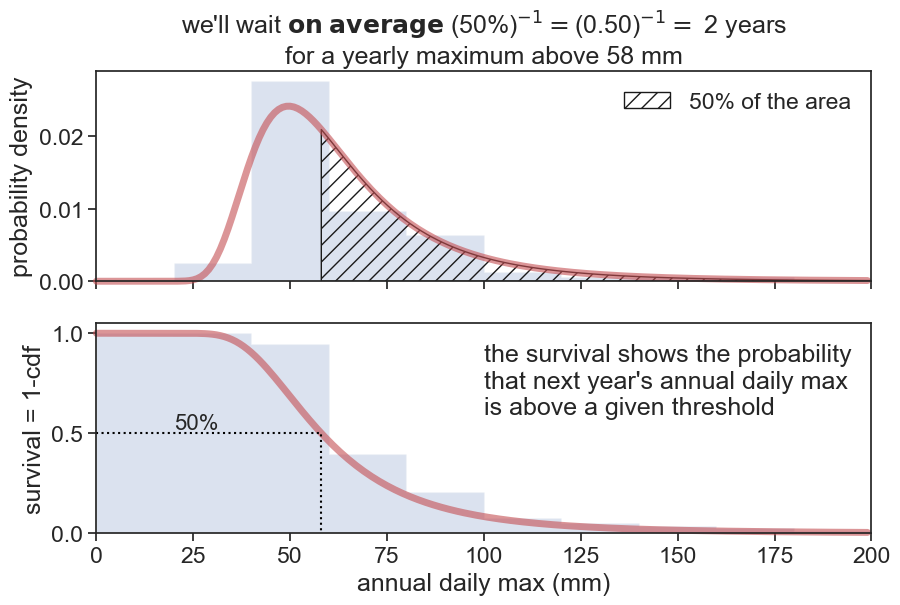

In [10]:
#| code-summary: "plot for survival = 0.5"
plot_pdf_and_survival(0.5)

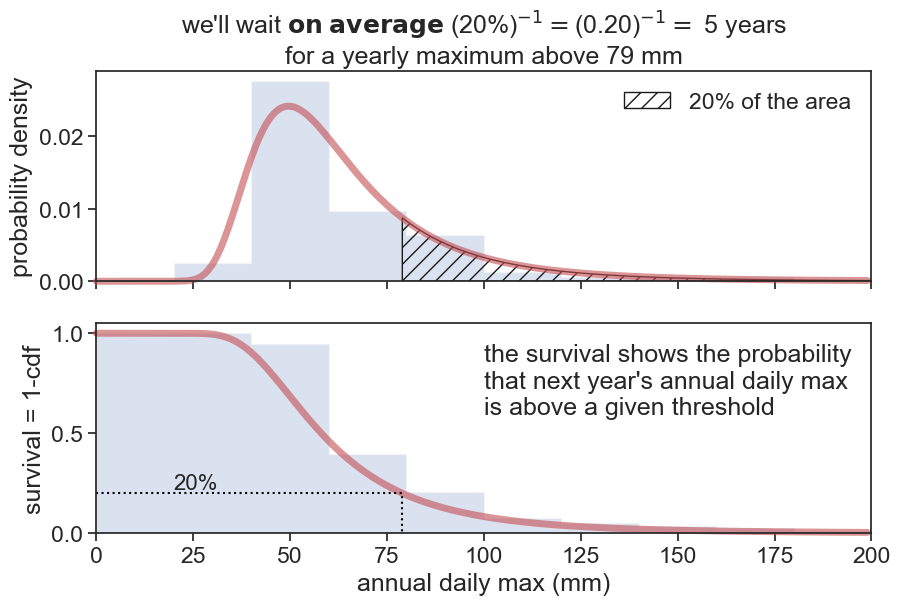

In [11]:
#| code-summary: "plot for survival = 0.2"
plot_pdf_and_survival(0.2)

## Return Period

We will follow @brutsaert2005hydrology, page 513.

We call $F(x)$ the CDF of the PDF $f(x)$. $F(x)$ indicates the non-exceedance probability, i.e., the probability that a certain event above $x$ has **not** occurred (or that an event below $x$ has occurred, same thing). The execeedance probability, also called survival probability, equals $1-F(x)$, and is the probability that a certain event above $x$ *has* occurred. It's reciprocal is the return period:

$$
T_r(x) = \frac{1}{1-F(x)}
$$

This return period is the expected number of observations required until $x$ is exceeded once.
In our case, we can ask the question: how many years will pass (on average) until we see a rainfall event greater that that of 26 August 1983?

Let's call $p=F(x)$ the probability that we measured once and that an event greater than $x$ has *not* occurred.
What is the probability that a rainfall above $x$ will occur only on year number $k$?  

* it hasn't occurred on year 1 (probability p)
* it hasn't occurred on year 2 (probability p)
* it hasn't occurred on year 3 (probability p)
* ...
* it has occurred on year k (probability 1-p)

$P\{k \text{ trials until }X>x\} = p^{k-1}(1-p)$

Every time the number $k$ will be different. What will be $k$ *on average*?

$$
\bar{k} = \displaystyle\sum_{k=1}^{\infty} k P(k) = \displaystyle\sum_{k=1}^{\infty} k p^{k-1}(1-p)
$$

Let's open that up:

$$
\begin{split}
\bar{k} &= 1-p + 2p(1-p) + 3p^2(1-p) + 4p^3(1-p)+ \cdots\\
\bar{k} &= 1-p + 2p - 2p^2 + 3p^2 - 3p^4 + 4p^3 - 4p^4+ \cdots \\
\bar{k} &= 1 + p + p^2 + p^3 + p^4 + \cdots
\end{split}
$$

For $p<1$, the series converges to
$$
1 + p + p^2 + p^3 + p^4 + \cdots = \frac{1}{1-p},
$$
therefore
$$
\bar{k} = \frac{1}{1-p}.
$$

We conclude that if we know the exceedance probability, we immediately can say what the return times are. We now need a way of estimating this exceedance probability.


## Generalized extreme value distribution

This part of the lecture was heavily inspired by Alexandre Martinez's excellent [blog post](https://sites.uci.edu/alexm/teaching-interests/calculating-return-level-of-extreme-precipitation-and-temperature-using-extrem-events-analysis/).

The Generalized Extreme Value (GEV) distribution is the limit distribution of properly normalized maxima of a sequence of independent and identically distributed random variables ([from Wikipedia](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution)).

It has three parameters:

* $\xi=$ shape,
* $\mu=$ location, 
* $\sigma=$ scale.

See a few examples of how the gev function looks for different parameters.

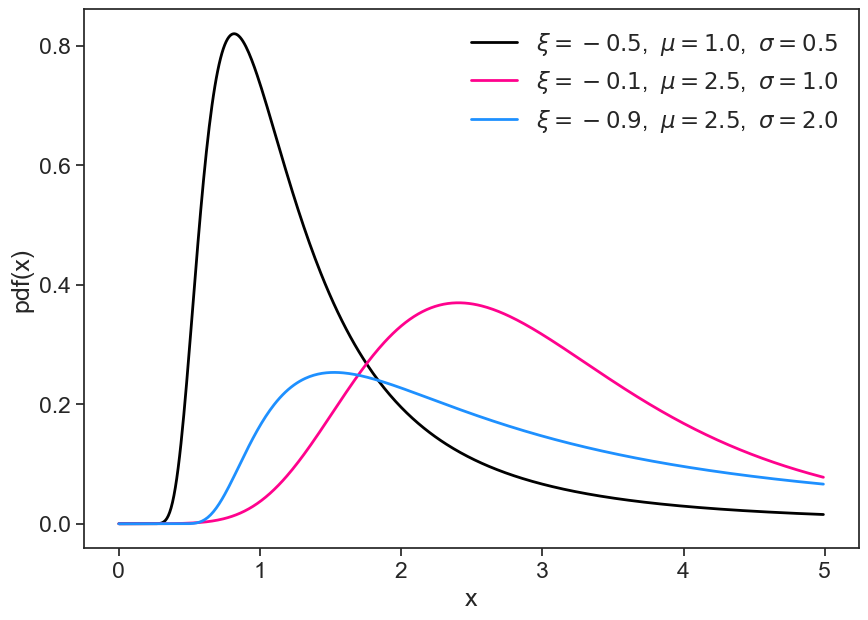

In [12]:
#| code-summary: "gev with different parameter values"
fig, ax = plt.subplots(figsize=(10,7))

shape = [-0.5, -0.1, -0.9]
location = [1.0, 2.5, 2.5]
scale = [0.5, 1.0, 2.0]
color=["black", "xkcd:hot pink", "dodgerblue"]
x = np.arange(0, 5, 0.01)
for i in range(len(shape)):
    pdf = genextreme.pdf(x, shape[i], loc=location[i], scale=scale[i])
    ax.plot(x, pdf, lw=2, color=color[i], label=rf"$\xi={shape[i]}$,  $\mu={location[i]}$,  $\sigma={scale[i]}$")
ax.legend(loc="upper right", frameon=False)
ax.set(xlabel="x",
       ylabel="pdf(x)");

Our task now is to find the "best curve" that describes our data. We do that by **fitting** the GEV curve, i.e., we need to find the best combination of parameters.

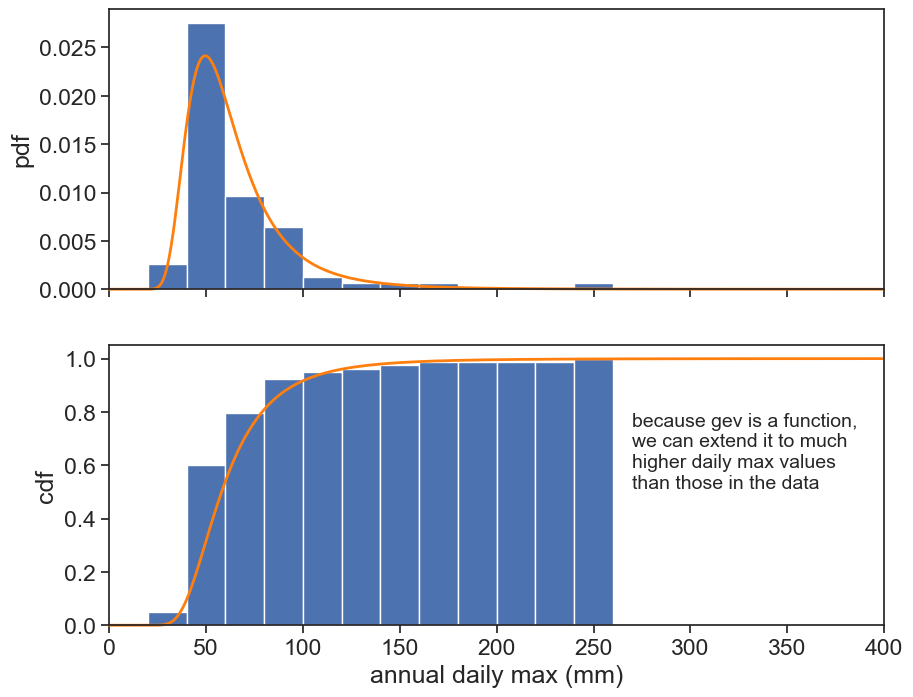

In [13]:
#| code-summary: "plot pdf and cdf"

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax1.hist(h, bins=bins, density=True)
ax2.hist(h, bins=bins, cumulative=1, density=True)

params = genextreme.fit(h)
rain_max = 400.0
rain = np.arange(0,rain_max)
pdf = genextreme(c=params[0], loc=params[1], scale=params[2]).pdf
cdf = genextreme(c=params[0], loc=params[1], scale=params[2]).cdf
ax1.plot(rain, pdf(rain), color='tab:orange', clip_on=False, lw=2)
ax2.plot(rain, cdf(rain), color='tab:orange', clip_on=False, lw=2)
ax2.text(270, 0.8, "because gev is a function,\nwe can extend it to much\nhigher daily max values\nthan those in the data",
         fontsize=14, va="top")

ax1.set(ylabel="pdf")
ax2.set(xlabel="annual daily max (mm)",
        ylabel="cdf",
        xlim=[0,400]
        );

### cdf from data

Here is a plot of annual daily precipitation maxima for Bilbao.

[Text(0, 0.5, 'annual daily precipitation max (mm)'), (0.0, 270.0)]

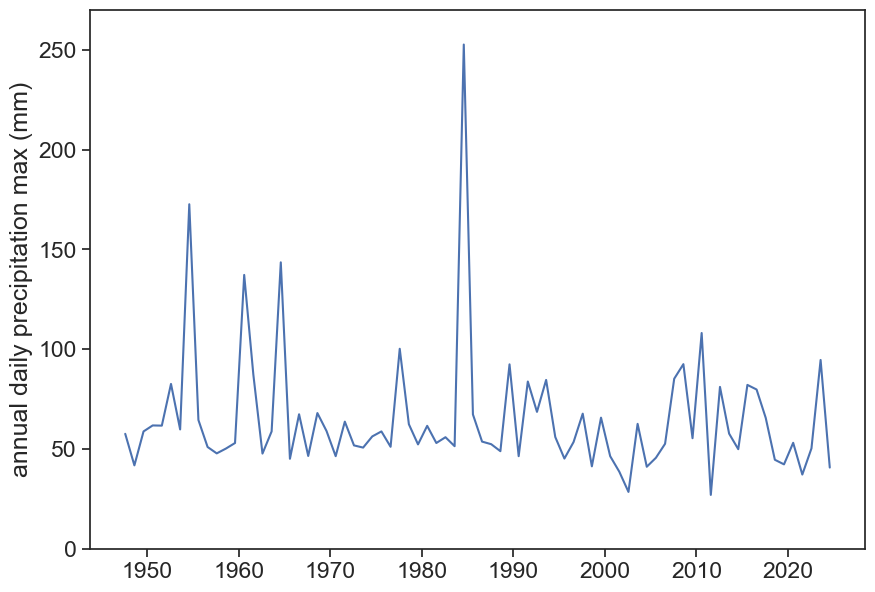

In [14]:
#| code-summary: "annual daily max for each year"
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(max_annual['PRCP'])
ax.set(ylabel="annual daily precipitation max (mm)",
       ylim=[0, 270])

There are 74 points here. Let's order them from small to large:

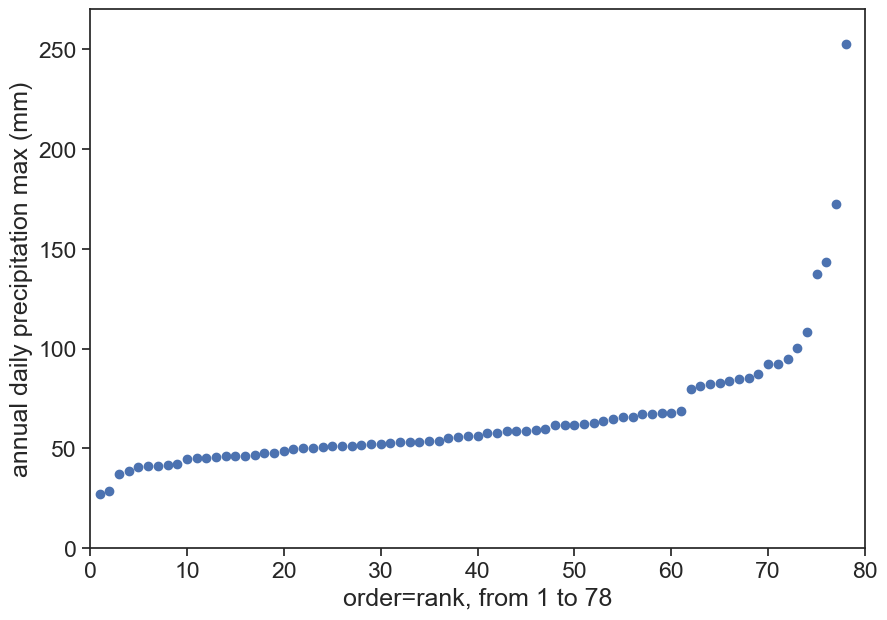

In [20]:
#| code-summary: "ordered annual daily max"
# sort yearly max from highest to lowest
max_annual = max_annual.sort_values(by=['PRCP'], ascending=True)
max_annual['rank'] = np.arange(1, len(max_annual) + 1)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(max_annual['rank'], max_annual['PRCP'], 'o')
ax.set(ylabel="annual daily precipitation max (mm)",
       xlabel=f"order=rank, from 1 to {len(max_annual)}",
       ylim=[0, 270],
       xlim=[0, 80]);

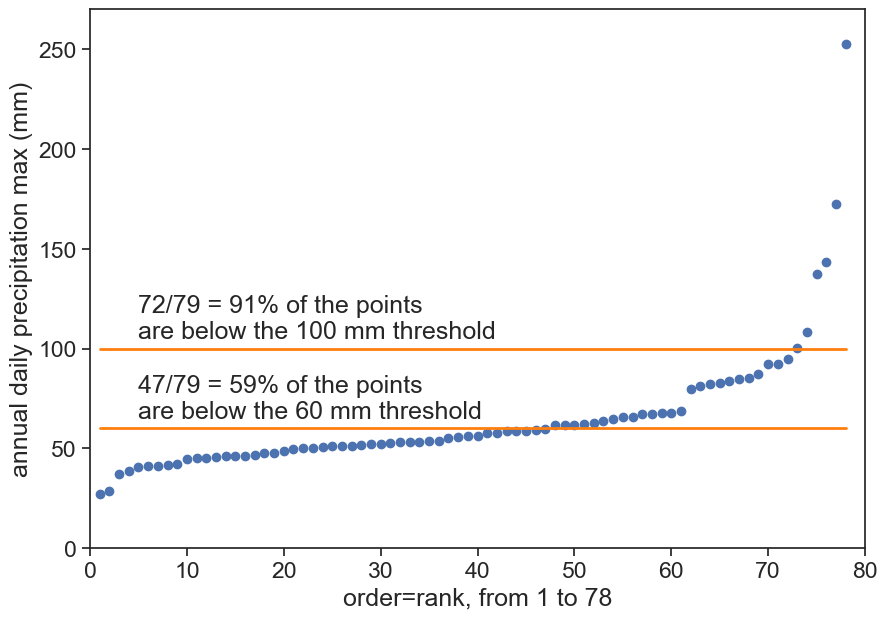

In [23]:
#| code-summary: "ordered annual daily max"

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(max_annual['rank'], max_annual['PRCP'], 'o')

n = len(max_annual['rank'])
m = max_annual['rank']
cdf_fromdata = m / (n+1)

threshold100 = 100  # millimeters
count100 = np.sum(max_annual['PRCP'] < threshold100)
p100 = count100/(n+1)
ax.text(5, 105, f"{count100}/{n+1} = {p100:.0%} of the points\nare below the {threshold100} mm threshold")
ax.plot(max_annual['rank'], threshold100 + 0*max_annual['PRCP'],
        color="tab:orange", lw=2)

threshold60 = 60  # millimeters
count60 = np.sum(max_annual['PRCP'] < threshold60)
p60 = count60/(n+1)
ax.text(5, 65, f"{count60}/{n+1} = {p60:.0%} of the points\nare below the {threshold60} mm threshold")
ax.plot(max_annual['rank'], threshold60 + 0*max_annual['PRCP'],
        color="tab:orange", lw=2)

ax.set(ylabel="annual daily precipitation max (mm)",
       xlabel=f"order=rank, from 1 to {len(max_annual)}",
       ylim=[0, 270],
       xlim=[0, 80]);

Now, instead of having the order of the event on the horizontal axis, let's make it a fraction from 0 to 1.

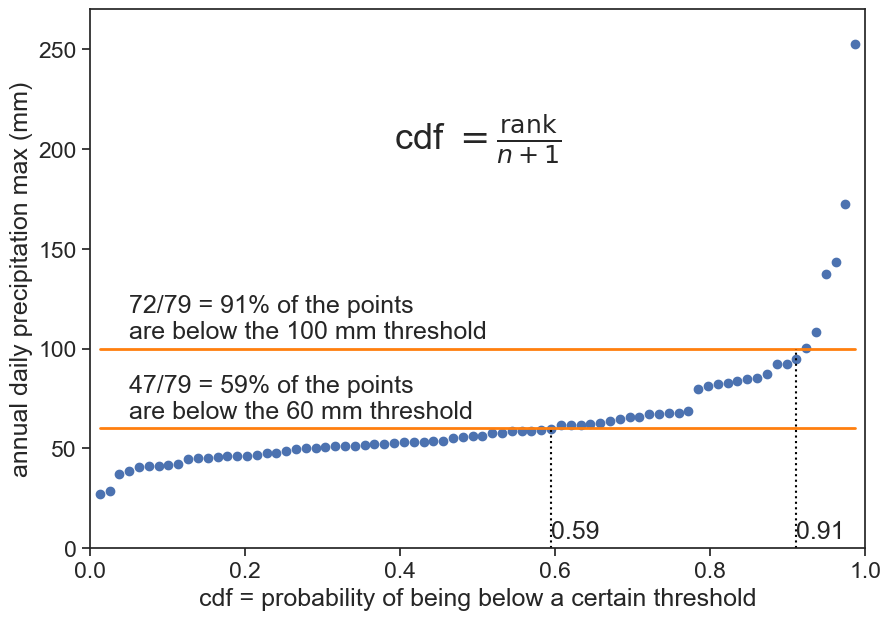

In [41]:
#| code-summary: "now horizontal axis is cdf"
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(cdf_fromdata, max_annual['PRCP'], 'o')
ax.text(0.05, 105, f"{count100}/{n+1} = {p100:.0%} of the points\nare below the {threshold100} mm threshold")
ax.plot(cdf_fromdata, threshold100 + 0*max_annual['PRCP'],
        color="tab:orange", lw=2)
ax.text(0.05, 65, f"{count60}/{n+1} = {p60:.0%} of the points\nare below the {threshold60} mm threshold")
ax.plot(cdf_fromdata, threshold60 + 0*max_annual['PRCP'],
        color="tab:orange", lw=2)
ax.plot([p100, p100], [0, threshold100], ls=":", color="black")
ax.text(p100, 5, f"{p100:.2f}")
ax.plot([p60, p60], [0, threshold60], ls=":", color="black")
ax.text(p60, 5, f"{p60:.2f}")
ax.text(0.5, 200, r"cdf $=\frac{\text{rank}}{n+1}$",
        fontsize=26, ha="center")
ax.set(ylabel="annual daily precipitation max (mm)",
       xlabel=f"cdf = probability of being below a certain threshold",
       ylim=[0, 270],
       xlim=[0, 1]);

The cdf was calculated using the Weibull plotting position:

$$
P_m = \frac{\text{rank}}{n+1}
$$

In the context of analyzing extreme values in precipitation, using the Weibull plotting position formula above is crucial for accurately estimating the cumulative distribution function (CDF). This method ensures a more even distribution of plotting positions, correcting the bias that often occurs with small sample sizes when using $n$ alone. By dividing by $n+1$, each rank's cumulative probability is slightly adjusted, resulting in more realistic and representative plotting positions. This adjustment is particularly important in hydrology and meteorology, where accurate representation of extreme precipitation events is essential for risk assessment and infrastructure planning. The Weibull plotting position thus provides a more reliable tool for understanding and predicting extreme weather patterns.

Now we just need to flip the vertical and horizontal axes, and we're done! We have our cdf!

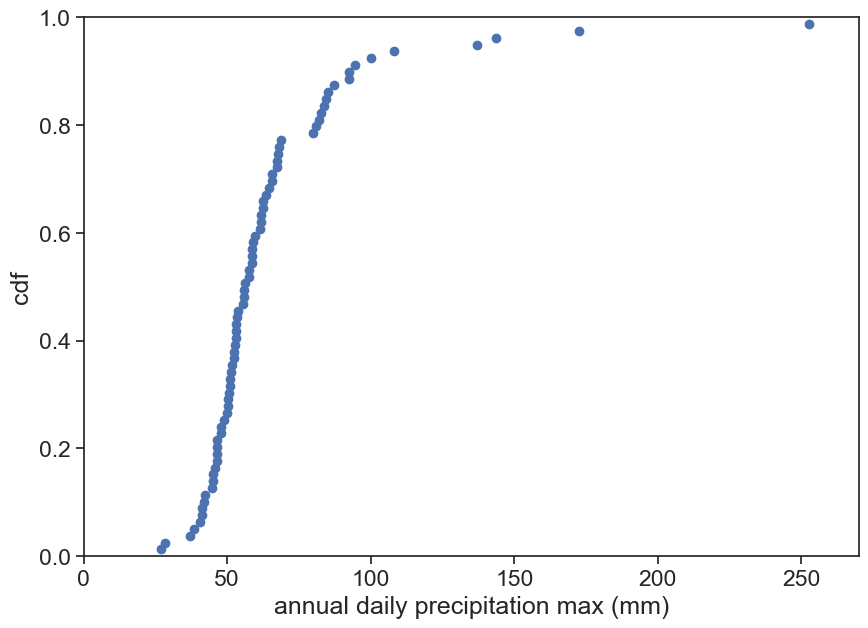

In [44]:
#| code-summary: "cdf as we are use to"
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(max_annual['PRCP'], cdf_fromdata, 'o')
ax.set(xlabel="annual daily precipitation max (mm)",
       ylabel=f"cdf",
       xlim=[0, 270],
       ylim=[0, 1]);

Let's compare this to the cumulative distribution from before, based on the histogram.

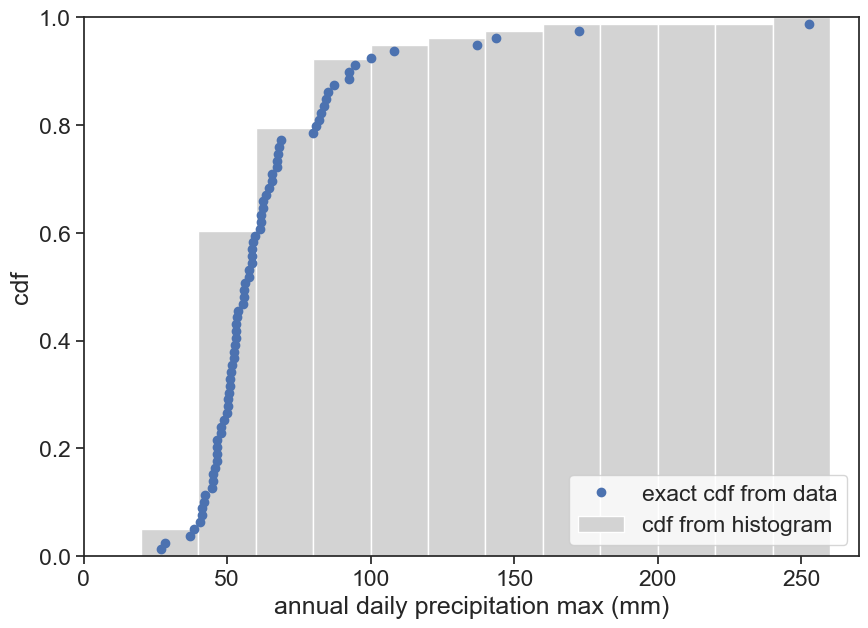

In [53]:
#| code-summary: "cdf as we are use to"
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(max_annual['PRCP'], cdf_fromdata, 'o', label="exact cdf from data")
ax.hist(h, bins=bins, cumulative=1, density=True, histtype="bar", color="lightgray", label="cdf from histogram")
ax.legend(loc="lower right")
ax.set(xlabel="annual daily precipitation max (mm)",
       ylabel=f"cdf",
       xlim=[0, 270],
       ylim=[0, 1]);

The highest data point in this graph goes only to 252 mm, corresponding to the highest event recorded in 74 years. We can use the GEV cdf to calculate return times for any desired levels, simply by converting the vertical axis (cdf) to return period, using the equation we found earlier.
$$
T_r(x) = \frac{1}{1-F(x)},
$$

where $T_r$ is the return period (in years), and $F$ is the cdf.

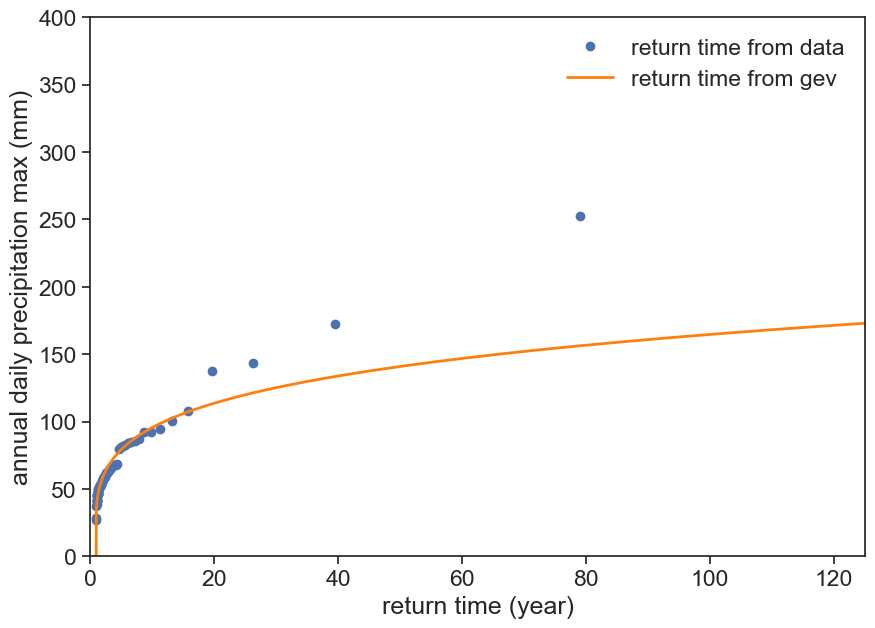

In [61]:
#| code-summary: "cdf as we are use to"
fig, ax = plt.subplots(figsize=(10,7))

T = 1 / (1-cdf_fromdata)
ax.plot(T, max_annual['PRCP'], 'o', label="return time from data")

ax.plot(1/(1-cdf(rain)), rain, color='tab:orange', lw=2, label="return time from gev")
ax.legend(loc="upper right", frameon=False)
ax.set(xlabel="return time (year)",
       ylabel=f"annual daily precipitation max (mm)",
       xlim=[0, 125],
       ylim=[0, 400]);


The information contained in the last two graphs is exactly the same, but somehow this last graph looks much worse! Why is this so?

